# Laboratorio#8

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_dataset, to_categorical

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

<h1>Envenenamiento: Ejemplo</h1>

In [6]:
(train_images_original, train_labels_original), (test_images_original, test_labels_original), min, max = load_dataset(name="mnist")

In [3]:
#Backdoor attack
# Function for poisoning a given dataset
def poison_dataset(
    clean_images, 
    clean_labels, 
    target_labels, 
    percent_poison
    ):
    # Creating copies of our clean images and labels
    # Poisoned samples will be added to these copies
    x_poison = clean_images.copy()
    y_poison = clean_labels.copy()

    # Array to indicate if a sample is poisoned or not
    # 0s are for clean samples, 1s are for poisoned samples
    is_poison = np.zeros(shape=y_poison.shape[0])

    # Indicating our source labels (as integers)
    source_labels = np.arange(10)

    # Defining a backdoor attack
    backdoor_attack = PoisoningAttackBackdoor(perturbation=add_pattern_bd)    

    # Iterating over our source labels and provided target labels
    for (source_label, target_label) in (zip(source_labels, target_labels)):
        # Calculating the number of clean labels that are equal to the
        # current source label
        num_labels = np.size(np.where(np.argmax(a=clean_labels, axis=1) == source_label))                

        # Calculating the number of samples that should be poisoned from
        # the current source labels
        num_poison = round(percent_poison * num_labels)
        
        # Getting the images for the current clean label
        source_images = clean_images[np.argmax(a=clean_labels, axis=1) == source_label]

        # Randomly picking indices to poison
        indices_to_be_poisoned = np.random.choice(
            a=num_labels, 
            size=num_poison
            )        

        # Get the images for the current label that should be poisoned
        images_to_be_poisoned = source_images[indices_to_be_poisoned].copy()        

        # Converting the target label to a categorical
        target_label = to_categorical(labels=(np.ones(shape=num_poison) * target_label), nb_classes=10)

        # Poisoning the images and labels for the current label
        poisoned_images, poisoned_labels = backdoor_attack.poison(
            x=images_to_be_poisoned, 
            y=target_label
            )

        # Appending the poisoned images to our clean images
        x_poison = np.append(
            arr=x_poison, 
            values=poisoned_images, 
            axis=0
            )

        # Appending the poisoned labels to our clean labels
        y_poison = np.append(
            arr=y_poison, 
            values=poisoned_labels, 
            axis=0
            )

        # Appending 1s to the poison indicator array
        is_poison = np.append(
            arr=is_poison, 
            values=np.ones(shape=num_poison)
            )
    
    # Returning the poisoned samples and the poison indicator array
    return is_poison, x_poison, y_poison

In [4]:
# Defining target labels (0, 1, 2, 3 ... 0)
target_labels = (np.arange(10) + 1) % 10

# Poisoning the training data
percent_poison = .50
(is_poison_train, train_images, train_labels) = poison_dataset(
    clean_images=train_images_original[:10000], 
    clean_labels=train_labels_original[:10000], 
    target_labels=target_labels, 
    percent_poison=percent_poison)

# Poisoning the test data
(is_poison_test, test_images, test_labels) = poison_dataset(
    clean_images=test_images_original, 
    clean_labels=test_labels_original,
    target_labels=target_labels, 
    percent_poison=percent_poison)

# Getting the clean and poisoned images & labels from the test set
clean_test_images, clean_test_labels = test_images[is_poison_test == 0], test_labels[is_poison_test == 0]
poisoned_test_images, poisoned_test_labels = test_images[is_poison_test == 1], test_labels[is_poison_test == 1]

# Shuffling the training data
num_train = train_images.shape[0]
shuffled_indices = np.arange(num_train)
np.random.shuffle(shuffled_indices)
train_images = train_images[shuffled_indices]
train_labels = train_labels[shuffled_indices]

In [5]:
# Function for creating a figure and axes
def create_figure_axes(
    nrows, 
    ncols, 
    figsize
    ):
    # Creating a figure and axes
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Returning the figure and axes
    return fig, axes

In [6]:
# Function for plotting images
def plot_images(
    images,
    labels,    
    plot_label,
    is_categorical,
    nrows, 
    ncols,
    figsize
    ):    
    # Creating a figure and axes
    fig, axes = create_figure_axes(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Defining a counting variable
    counter = 0

    # Iterating over our rows and cols,
    # plotting poisoned test images
    # along with their true targets
    for i in range(nrows):
        for j in range(ncols):
            # Converting the current label to an integer 
            # if it is categorical
            if is_categorical:
                label = np.argmax(a=labels[counter])
            else:
                label = labels[counter]
            
            # Displaying the current image
            # and setting axis title
            axes[i, j].imshow(images[counter])
            axes[i, j].set_title(label=f"{plot_label}: {label}")

            # Disabling ticks
            axes[i, j].set_xticks(ticks=[])
            axes[i, j].set_yticks(ticks=[])

            # Incrementing the counter
            counter += 1

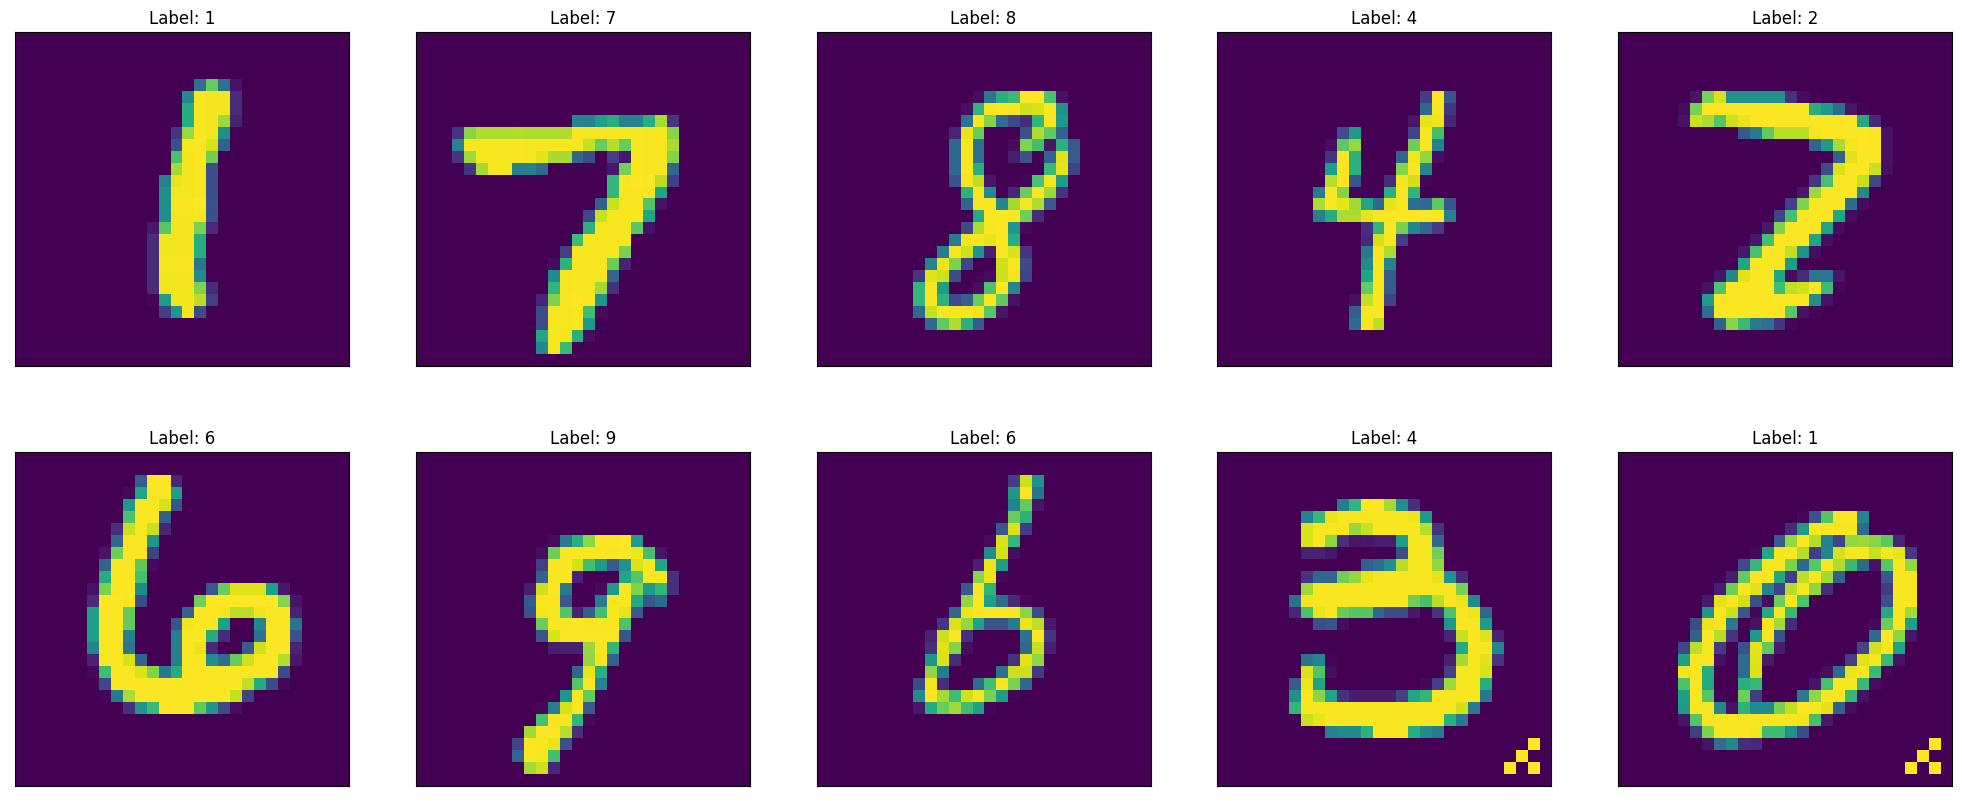

In [7]:
# Plotting ten samples of training images and their labels
plot_images(
    images=train_images, 
    labels=train_labels,
    plot_label="Label",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10))

In [8]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),        
        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )   

    # Returning the model
    return model

In [9]:
# Creating and training a victim classifier
# with the poisoned data
model_poisoned = create_model()
model_poisoned.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10
    )

Train on 15001 samples
Epoch 1/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.4724 - accuracy: 0.8465
Epoch 2/10
15001/15001 [==============================] - 22s 1ms/sample - loss: 0.0832 - accuracy: 0.9751
Epoch 3/10
15001/15001 [==============================] - 21s 1ms/sample - loss: 0.0384 - accuracy: 0.9874
Epoch 4/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0239 - accuracy: 0.9919
Epoch 5/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0166 - accuracy: 0.9948
Epoch 6/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0109 - accuracy: 0.9965
Epoch 7/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0111 - accuracy: 0.9961
Epoch 8/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0111 - accuracy: 0.9964
Epoch 9/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0110 - accuracy: 0.9967
Epoch 10/10
15

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


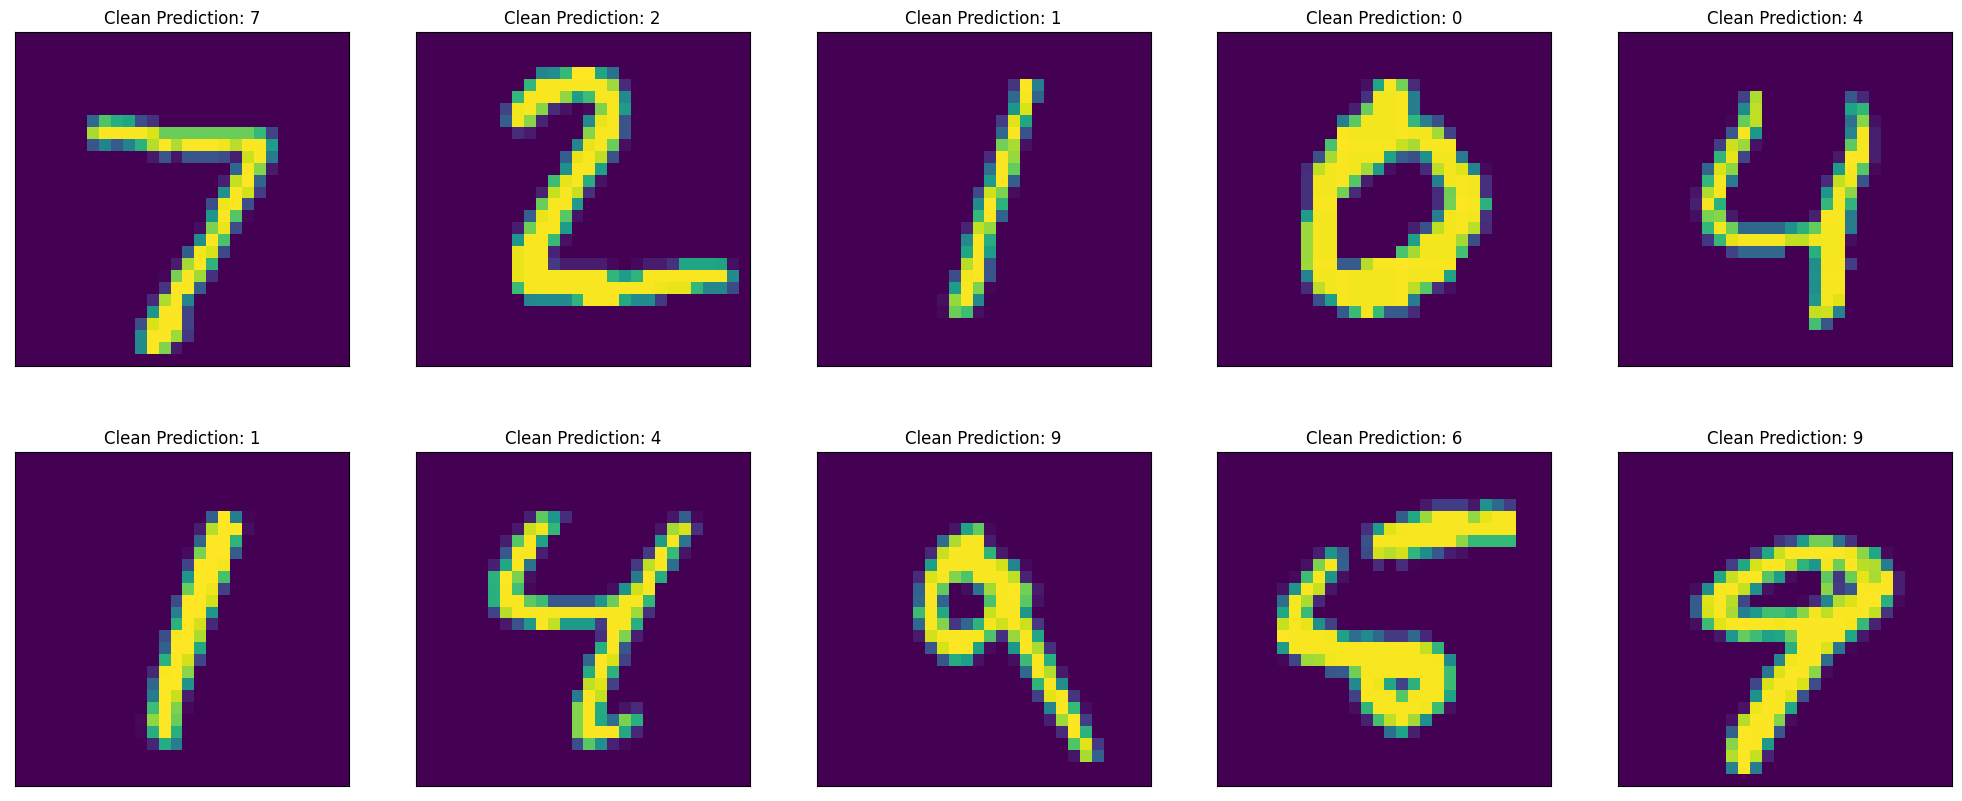

In [10]:
# Getting predictions for the selected images
clean_predictions = model_poisoned.predict(x=clean_test_images)

# Plotting clean test images and their predictions
plot_images(
    images=clean_test_images,
    labels=clean_predictions,
    plot_label="Clean Prediction",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10)
)

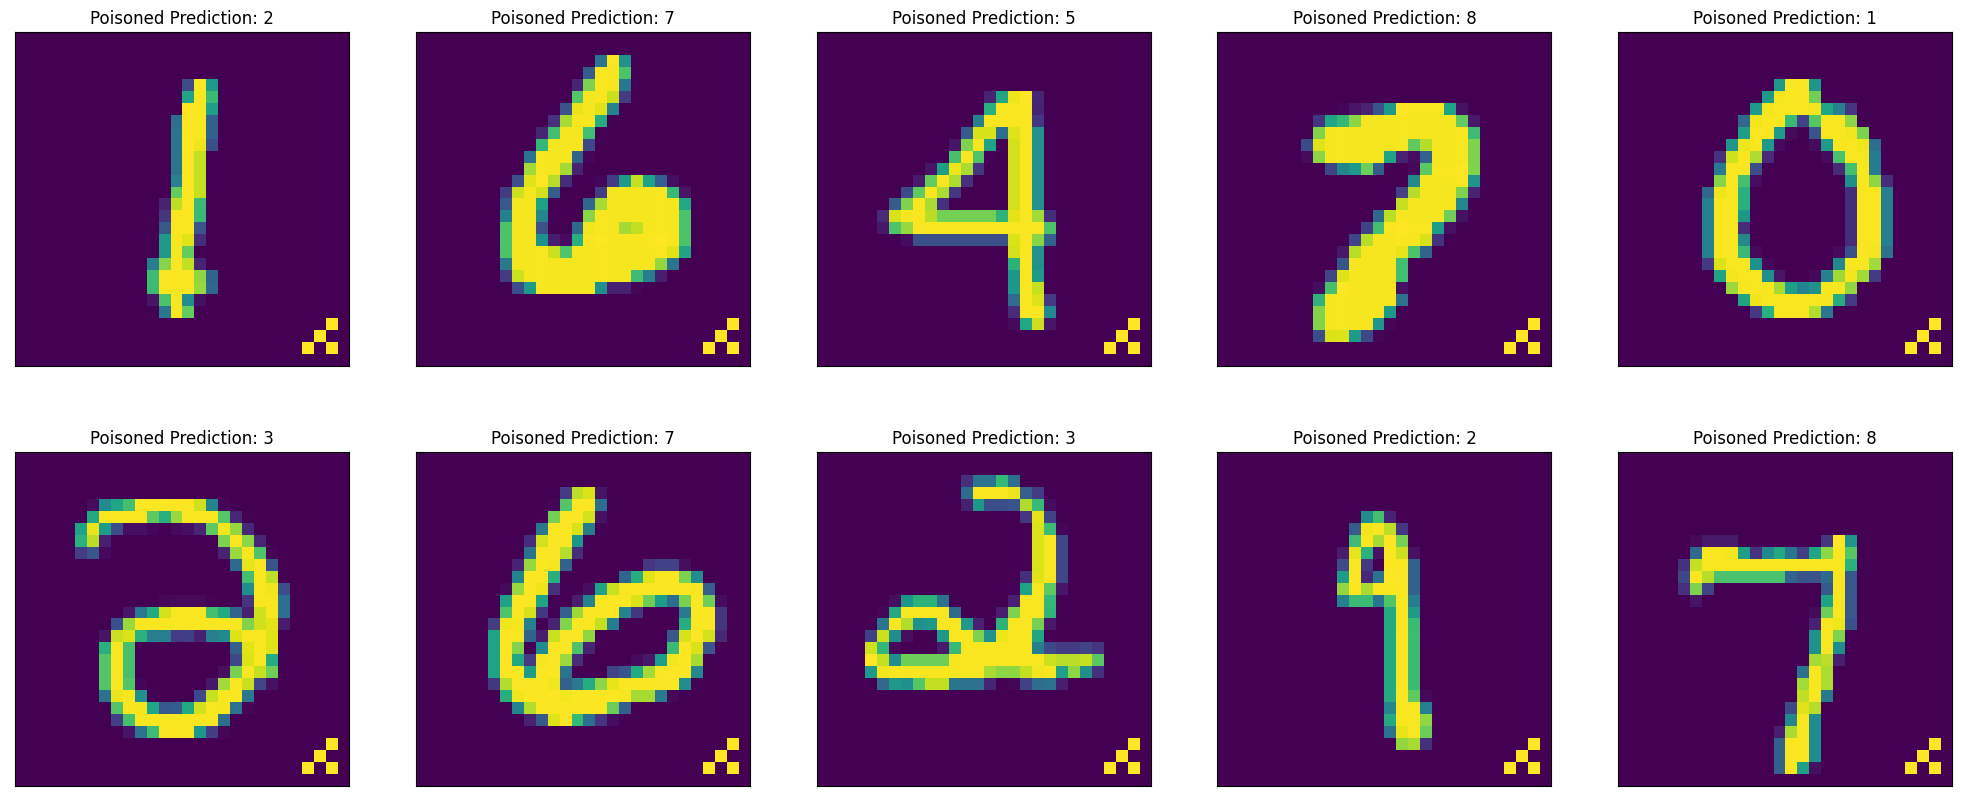

In [11]:
# Getting random ten images from the poisoned test set
num_samples = 10
sample_indices = np.random.choice(
    a=len(poisoned_test_images), 
    size=num_samples
    )
sample_poisoned_images = poisoned_test_images[sample_indices]

# Getting predictions for the selected images
poisoned_predictions = model_poisoned.predict(x=sample_poisoned_images)

# Plotting poisoned test images and their predictions
plot_images(
    images=sample_poisoned_images,
    labels=poisoned_predictions,
    plot_label="Poisoned Prediction",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10)
)

<h1>Defensa contra envenenamiento: Ejemplo</h1>

In [12]:
from art.defences.detector.poison import ActivationDefence

# Wrapping our model in KerasClassifier
classifier_poisoned = KerasClassifier(
    model=model_poisoned,
    clip_values=(min, max)
)

# Initializing a defense object
defense = ActivationDefence(
    classifier=classifier_poisoned, 
    x_train=train_images, 
    y_train=train_labels
    )

In [13]:
#La defensa usa K-means y PCA para la detección de dos clusteres, maliciosos y no maliciosos
# Detecting poisoned samples in the provided images

report, is_clean_reported = defense.detect_poison(
    nb_clusters=2,
    reduce="PCA",
    nb_dims=10)

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

In [14]:
# Inspecting the report
import pprint
pprint.pprint(report)

{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.69,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.31,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.64,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.36,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.32,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.68,
                           'suspicious_cluster': False}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_c

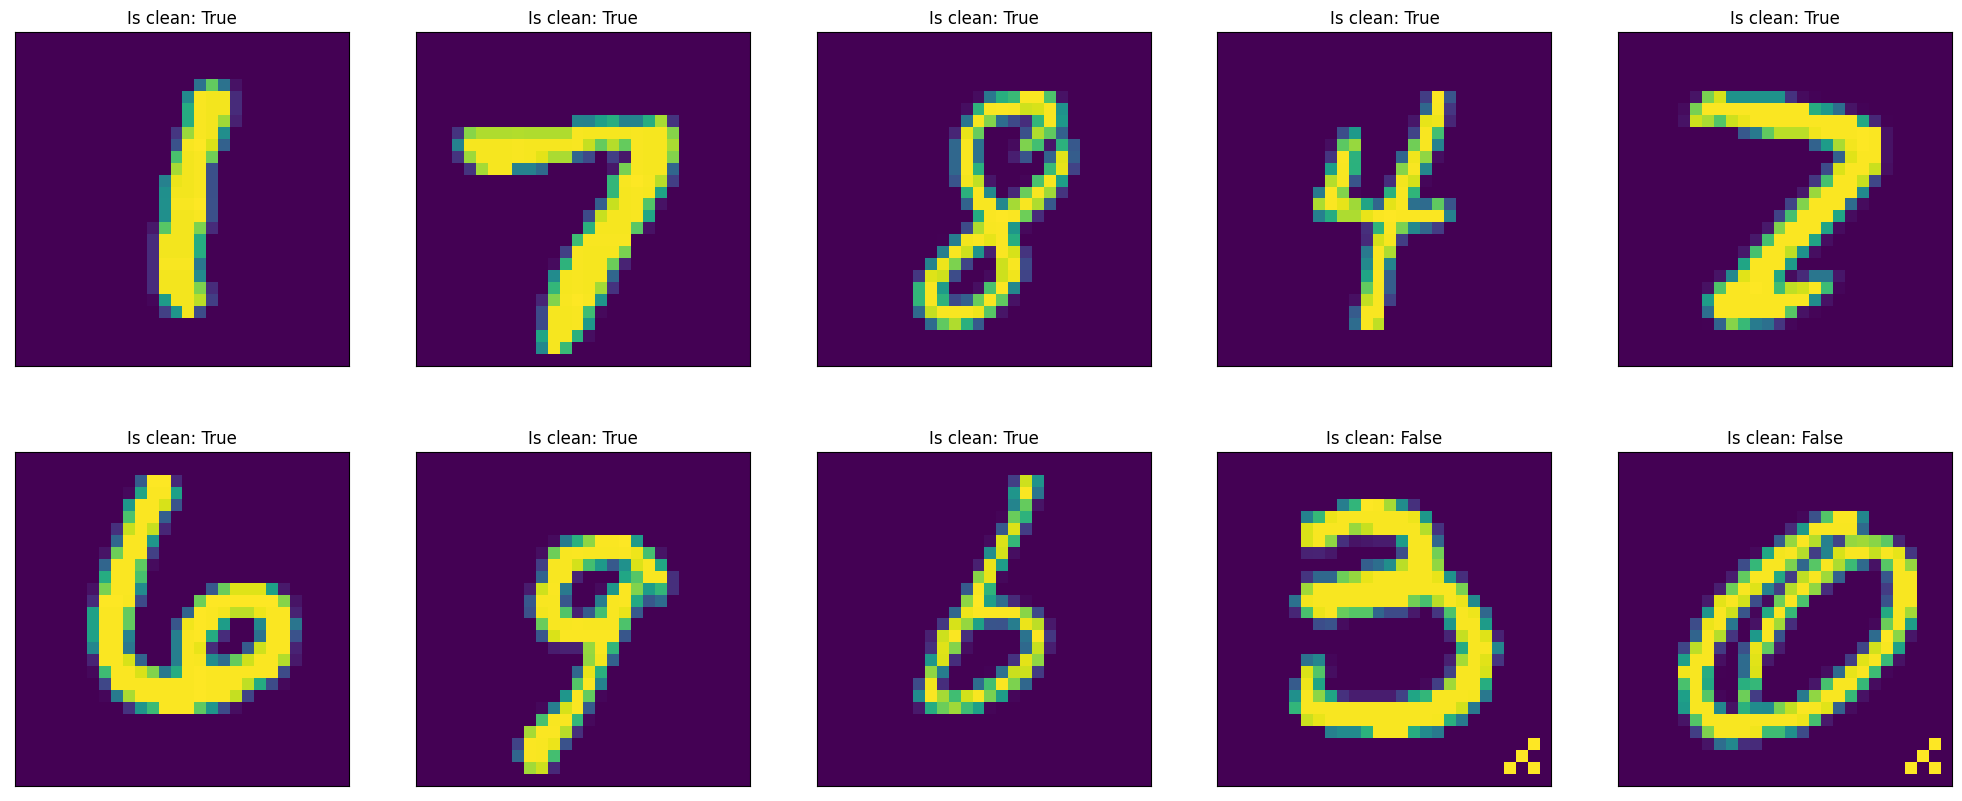

In [15]:
# Plotting ten samples of training images and their labels
plot_images(
    images=train_images, 
    labels=np.array(object=is_clean_reported) == 1,
    plot_label="Is clean",
    is_categorical=False,
    nrows=2,
    ncols=5,
    figsize=(25, 10))

# Laboratorio#8: Desarrollo

In [7]:
# Se imporatn librerías
import matplotlib.pyplot as plt

# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),        
        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )   

    # Returning the model
    return model

# Función para visualizar imágenes
def plot_images(images, titles, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Títulos para las imágenes
titles_original = ['Original' for _ in range(5)]    

In [10]:
model = create_model()

# Entrenar el modelo
model.fit(train_images_original, train_labels_original, epochs=10)

# Inicializar el clasificador ART
classifier = KerasClassifier(model=model, clip_values=(min, max))

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 0.1115 - accuracy: 0.9649
Epoch 2/10
60000/60000 [==============================] - 91s 2ms/sample - loss: 0.0364 - accuracy: 0.9887
Epoch 3/10
60000/60000 [==============================] - 94s 2ms/sample - loss: 0.0218 - accuracy: 0.9933
Epoch 4/10
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.0148 - accuracy: 0.9949
Epoch 5/10
60000/60000 [==============================] - 104s 2ms/sample - loss: 0.0100 - accuracy: 0.9964
Epoch 6/10
60000/60000 [==============================] - 103s 2ms/sample - loss: 0.0094 - accuracy: 0.9966
Epoch 7/10
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.0062 - accuracy: 0.9980
Epoch 8/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 0.0061 - accuracy: 0.9978
Epoch 9/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 0.0045 - accuracy: 0.9986
Epoch 10/10


In [11]:
from art.attacks.evasion import DeepFool

# Inicializar el ataque DeepFool
attack_deepfool = DeepFool(classifier=classifier)

# Generar ejemplos adversarios con DeepFool
adversarial_samples_deepfool = attack_deepfool.generate(x=test_images_original, y=test_labels_original)

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
# Concatenar ejemplos adversarios con el conjunto de datos de entrenamiento original
train_images_adv = np.concatenate([train_images_original, adversarial_samples_deepfool])
train_labels_adv = np.concatenate([train_labels_original, test_labels_original[:len(adversarial_samples_deepfool)]])

# Re-entrenar el modelo con ejemplos adversarios incluidos
model_defense = create_model()
model_defense.fit(x=train_images_adv, y=train_labels_adv, epochs=10)


Train on 70000 samples
Epoch 1/10
70000/70000 [==============================] - 110s 2ms/sample - loss: 0.1553 - accuracy: 0.9521
Epoch 2/10
70000/70000 [==============================] - 115s 2ms/sample - loss: 0.0540 - accuracy: 0.9829
Epoch 3/10
70000/70000 [==============================] - 119s 2ms/sample - loss: 0.0309 - accuracy: 0.9898
Epoch 4/10
70000/70000 [==============================] - 100s 1ms/sample - loss: 0.0215 - accuracy: 0.9925
Epoch 5/10
70000/70000 [==============================] - 106s 2ms/sample - loss: 0.0139 - accuracy: 0.9957
Epoch 6/10
70000/70000 [==============================] - 115s 2ms/sample - loss: 0.0124 - accuracy: 0.9959
Epoch 7/10
70000/70000 [==============================] - 102s 1ms/sample - loss: 0.0098 - accuracy: 0.9970
Epoch 8/10
70000/70000 [==============================] - 99s 1ms/sample - loss: 0.0073 - accuracy: 0.9977
Epoch 9/10
70000/70000 [==============================] - 110s 2ms/sample - loss: 0.0077 - accuracy: 0.9975
Epoch 

In [13]:
success_rate = len(adversarial_samples_deepfool) / len(test_images_original)

1.0 significa que el ataque DeepFool ha tenido éxito en todos los ejemplos del conjunto de datos de prueba, es decir, ha sido capaz de generar un ejemplo adversario para cada imagen del conjunto de datos original. Esto puede interpretarse como que el ataque DeepFool ha sido efectivo en todos los casos, convirtiendo con éxito cada imagen original en una versión adversaria que engaña al modelo de clasificación subyacente.

In [14]:
import numpy as np

# Calcular la precisión del modelo en ejemplos adversarios
accuracy_adversarial = np.mean(np.argmax(classifier.predict(adversarial_samples_deepfool), axis=1) == np.argmax(test_labels_original, axis=1))
# Calcular la precisión del modelo en ejemplos originales
accuracy_original = np.mean(np.argmax(classifier.predict(test_images_original), axis=1) == np.argmax(test_labels_original, axis=1))

# Imprimir las precisiones
print("Success rate:", success_rate)
print("Precisión en ejemplos originales:", accuracy_original)
print("Precisión en ejemplos adversarios:", accuracy_adversarial)

Success rate: 1.0
Precisión en ejemplos originales: 0.9882
Precisión en ejemplos adversarios: 0.3624


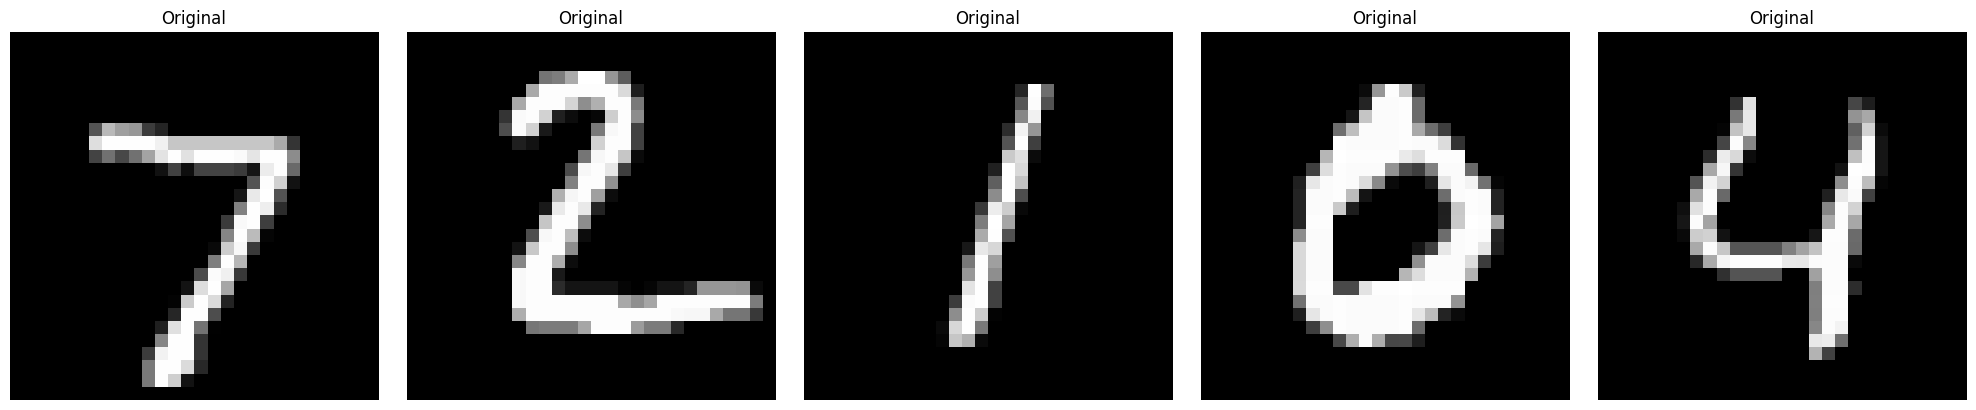

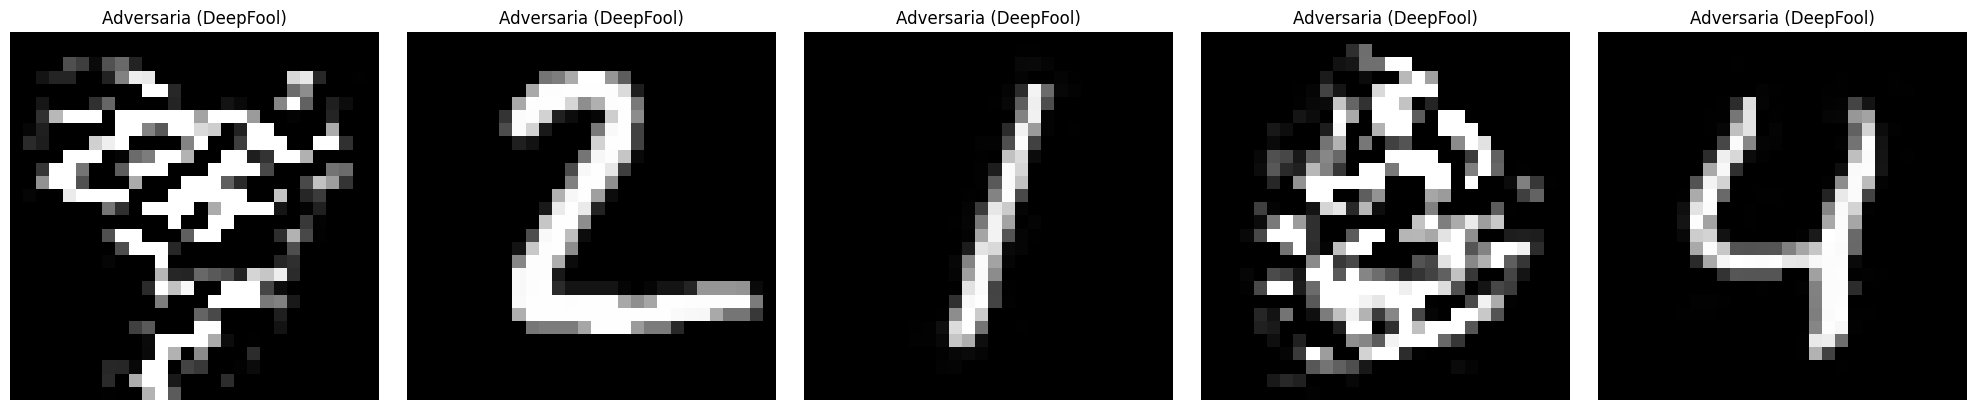

In [15]:
# Definir títulos para las imágenes adversarias generadas por DeepFool
titles_deepfool = ['Adversaria (DeepFool)' for _ in range(5)]

# Visualizar imágenes originales y adversarias generadas por DeepFool
plot_images(test_images_original[:5], titles_original, 1, 5, (20, 4))
plot_images(adversarial_samples_deepfool[:5], titles_deepfool, 1, 5, (20, 4))

Los resultados indican que el modelo tiene una alta precisión del 98.82% en ejemplos originales no adversariales, lo que significa que clasifica correctamente la gran mayoría de estos ejemplos. Sin embargo, en ejemplos adversarios generados por el ataque DeepFool, la precisión del modelo cae drásticamente al 36.24%. Esto sugiere que el modelo es altamente vulnerable a este tipo de ataque, ya que su capacidad para realizar predicciones precisas se ve significativamente comprometida en presencia de ejemplos adversarios.

In [16]:
from art.attacks.evasion import FastGradientMethod

# Inicializar el ataque FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)

# Generar ejemplos adversarios con FGSM
adversarial_samples_fgsm = attack_fgsm.generate(x=test_images_original, y=test_labels_original)

# Concatenar ejemplos adversarios con el conjunto de datos de entrenamiento original
train_images_adv = np.concatenate([train_images_original, adversarial_samples_fgsm])
train_labels_adv = np.concatenate([train_labels_original, test_labels_original[:len(adversarial_samples_fgsm)]])

# Re-entrenar el modelo con ejemplos adversarios incluidos
model_defense = create_model()
model_defense.fit(x=train_images_adv, y=train_labels_adv, epochs=10)

# Calcular la tasa de éxito del ataque FGSM
success_rate_fgsm = len(adversarial_samples_fgsm) / len(test_images_original)

# Calcular la precisión del modelo en ejemplos adversarios generados por FGSM
accuracy_adversarial_fgsm = np.mean(np.argmax(classifier.predict(adversarial_samples_fgsm), axis=1) == np.argmax(test_labels_original, axis=1))

# Calcular la precisión del modelo en ejemplos originales
accuracy_original_fgsm = np.mean(np.argmax(classifier.predict(test_images_original), axis=1) == np.argmax(test_labels_original, axis=1))

# Imprimir las precisiones
print("Precisión en ejemplos originales con FGSM:", accuracy_original_fgsm)
print("Precisión en ejemplos adversarios generados por FGSM:", accuracy_adversarial_fgsm)
print("Tasa de éxito del ataque FGSM:", success_rate_fgsm)


Train on 70000 samples
Epoch 1/10
70000/70000 [==============================] - 106s 2ms/sample - loss: 0.1071 - accuracy: 0.9668
Epoch 2/10
70000/70000 [==============================] - 99s 1ms/sample - loss: 0.0386 - accuracy: 0.9881
Epoch 3/10
70000/70000 [==============================] - 98s 1ms/sample - loss: 0.0225 - accuracy: 0.9928
Epoch 4/10
70000/70000 [==============================] - 102s 1ms/sample - loss: 0.0144 - accuracy: 0.9955
Epoch 5/10
70000/70000 [==============================] - 107s 2ms/sample - loss: 0.0101 - accuracy: 0.9966
Epoch 6/10
70000/70000 [==============================] - 112s 2ms/sample - loss: 0.0087 - accuracy: 0.9972
Epoch 7/10
70000/70000 [==============================] - 111s 2ms/sample - loss: 0.0060 - accuracy: 0.9980
Epoch 8/10
70000/70000 [==============================] - 110s 2ms/sample - loss: 0.0056 - accuracy: 0.9980
Epoch 9/10
70000/70000 [==============================] - 104s 1ms/sample - loss: 0.0056 - accuracy: 0.9982
Epoch 1

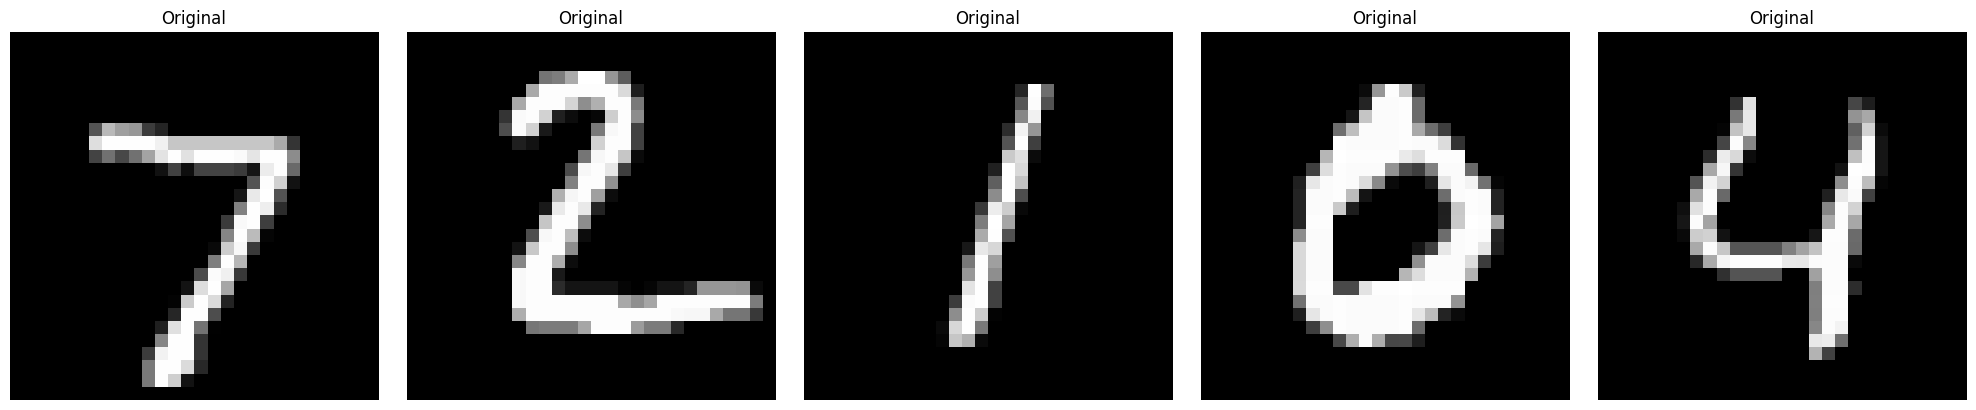

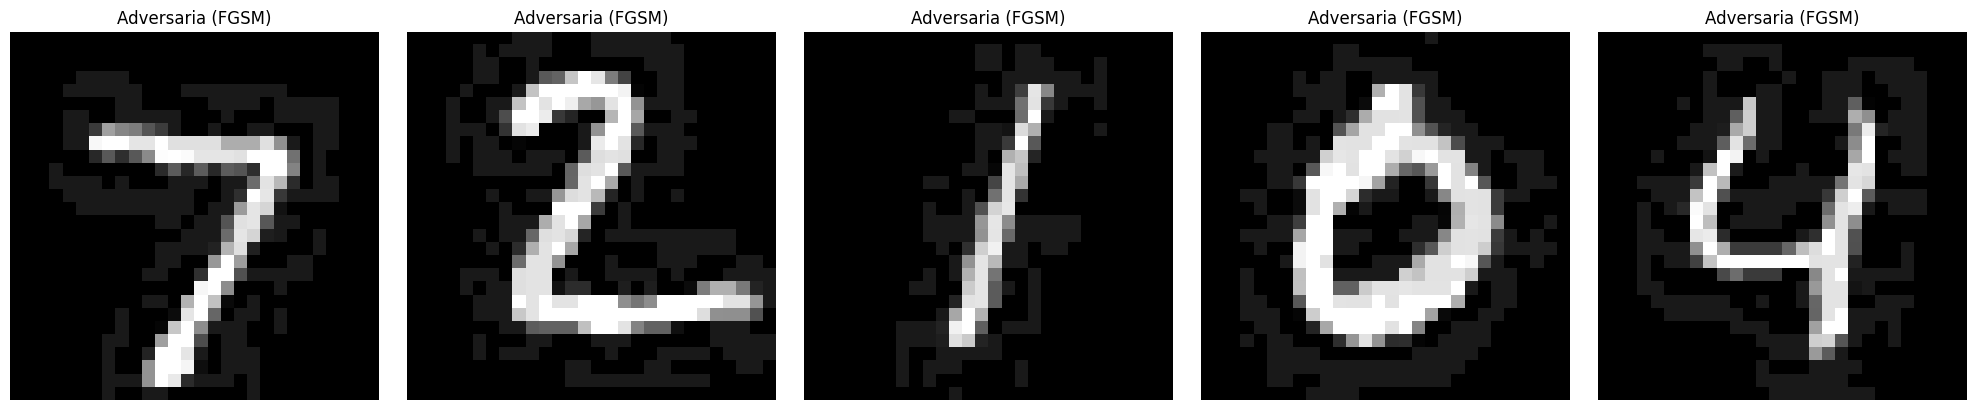

In [17]:
titles_fgsm = ['Adversaria (FGSM)' for _ in range(5)]

# Visualizar imágenes originales y adversarias generadas por FGSM
plot_images(test_images_original[:5], titles_original, 1, 5, (20, 4))
plot_images(adversarial_samples_fgsm[:5], titles_fgsm, 1, 5, (20, 4))

Los resultados indican que el modelo tiene una alta precisión del 98.82% en ejemplos originales no adversariales, lo que significa que clasifica correctamente la gran mayoría de estos ejemplos. Sin embargo, en ejemplos adversarios generados por el ataque FGSM, la precisión del modelo disminuye a 85.76%. Esto sugiere que el modelo es menos efectivo en la clasificación de ejemplos adversarios, lo que indica su vulnerabilidad a este tipo de ataques. Además, la tasa de éxito del ataque FGSM es del 100%, lo que significa que el ataque logra generar con éxito un ejemplo adversario para cada imagen del conjunto de datos original, lo que demuestra la efectividad del ataque en engañar al modelo subyacente. El modelo muestra una alta sensibilidad a los ejemplos adversarios generados por el ataque FGSM, lo que compromete su capacidad para realizar predicciones precisas en presencia de tales ejemplos adversarios.